In [2]:
import pandas as pd
import numpy as np 

# Needleman-Wunsch Algorithm 1

In [38]:
import numpy as np

def needleman_wunsch(seq1, seq2, match_score, mismatch_penalty, gap_penalty):
    # Initialize the alignment matrix
    n = len(seq1) + 1
    m = len(seq2) + 1
    matrix = np.zeros((m, n), dtype=int)

    # Initialize the first row and column with gap penalties
    for i in range(m):
        matrix[i][0] = i * gap_penalty
    for j in range(n):
        matrix[0][j] = j * gap_penalty

    # Fill in the matrix using the Needleman-Wunsch algorithm
    for i in range(1, m):
        for j in range(1, n):
            match = matrix[i-1][j-1] + (match_score if seq1[j-1] == seq2[i-1] else mismatch_penalty)
            delete = matrix[i-1][j] + gap_penalty
            insert = matrix[i][j-1] + gap_penalty
            matrix[i][j] = max(match, delete, insert)

    # Traceback to find the optimal alignment
    align1 = ""
    align2 = ""
    i, j = m - 1, n - 1
    while i > 0 and j > 0:
        score = matrix[i][j]
        score_diag = matrix[i-1][j-1]
        score_up = matrix[i][j-1]
        score_left = matrix[i-1][j]
        if score == score_diag + (match_score if seq1[j-1] == seq2[i-1] else mismatch_penalty):
            align1 = seq1[j-1] + align1
            align2 = seq2[i-1] + align2
            i -= 1
            j -= 1
        elif score == score_left + gap_penalty:
            align1 = '-' + align1
            align2 = seq2[i-1] + align2
            i -= 1
        elif score == score_up + gap_penalty:
            align1 = seq1[j-1] + align1
            align2 = '-' + align2
            j -= 1

    # Fill in the rest of the alignment if sequences have different lengths
    while i > 0:
        align1 = '-' + align1
        align2 = seq2[i-1] + align2
        i -= 1
    while j > 0:
        align1 = seq1[j-1] + align1
        align2 = '-' + align2
        j -= 1

    return align1, align2, matrix[-1][-1]  # Return the aligned sequences and the alignment score

# Example usage:
seq1 = "HEAGAWGHEE"
seq2 = "PAWHEAE"
match_score = 2  # Score for a match
mismatch_penalty = -2  # Penalty for a mismatch
gap_penalty = -2  # Penalty for a gap

aligned_seq1, aligned_seq2, alignment_score = needleman_wunsch(seq1, seq2, match_score, mismatch_penalty, gap_penalty)
print("Alignment score:", alignment_score)
print("Aligned sequence 1:", aligned_seq1)
print("Aligned sequence 2:", aligned_seq2)





Alignment score: -2
Aligned sequence 1: HEAGAWGHE-E
Aligned sequence 2: ---PAW-HEAE


# Smith Waterman

In [39]:
def smith_waterman(seq1, seq2, match_score, mismatch_penalty, gap_penalty):
    # Step 1: Initialize the score matrix (first row and column start with 0)
    m, n = len(seq1), len(seq2)
    score_matrix = [[0 for _ in range(n+1)] for _ in range(m+1)]

    # Step 2: Fill the score matrix (include 0 as a possible score)
    max_score = 0
    max_pos = None
    for i in range(1, m+1):
        for j in range(1, n+1):
            match = score_matrix[i-1][j-1] + (match_score if seq1[i-1] == seq2[j-1] else mismatch_penalty)
            delete = score_matrix[i-1][j] + gap_penalty
            insert = score_matrix[i][j-1] + gap_penalty
            score_matrix[i][j] = max(0, match, delete, insert)  # Include 0 in the max function
            # Keep track of the maximum score in the matrix
            if score_matrix[i][j] > max_score:
                max_score = score_matrix[i][j]
                max_pos = (i, j)

    # Step 3: Trace-back to find the optimal local alignment (start at max score)
    align1, align2 = '', ''
    i, j = max_pos
    while i > 0 and j > 0 and score_matrix[i][j] > 0:
        score_current = score_matrix[i][j]
        score_diagonal = score_matrix[i-1][j-1]
        score_up = score_matrix[i][j-1]
        score_left = score_matrix[i-1][j]
        
        if score_current == score_diagonal + (match_score if seq1[i-1] == seq2[j-1] else mismatch_penalty):
            align1 += seq1[i-1]
            align2 += seq2[j-1]
            i -= 1
            j -= 1
        elif score_current == score_left + gap_penalty:
            align1 += seq1[i-1]
            align2 += '-'
            i -= 1
        elif score_current == score_up + gap_penalty:
            align1 += '-'
            align2 += seq2[j-1]
            j -= 1
        else:
            break  # This case is reached if score_current is 0

    # Since we traversed the score matrix from the max scoring cell, we need to reverse the alignments
    align1 = align1[::-1]
    align2 = align2[::-1]

    return align1, align2, max_score

# Example usage (uncomment to run):
seq1 = "HEAGAWGHEE"
seq2 = "PAWHEAE"
match_score = 3
mismatch_penalty = -2
gap_penalty = -1
aligned_seq1, aligned_seq2, max_alignment_score = smith_waterman(seq1, seq2, match_score, mismatch_penalty, gap_penalty)
print("Aligned Sequences:\n", aligned_seq1, "\n", aligned_seq2)
print("Max Alignment Score:", max_alignment_score)


Aligned Sequences:
 AWGHE-E 
 AW-HEAE
Max Alignment Score: 13


# HMM

In [52]:
import numpy as np

# Define the states and emission probabilities
states = ['Fair', 'Loaded']
state_transition_probs = {
    'Fair': {'Fair': 0.9, 'Loaded': 0.1},
    'Loaded': {'Fair': 0.1, 'Loaded': 0.9}
}
emission_probs = {
    'Fair': [1/6]*6,
    'Loaded': [1/10]*5 + [1/2]
}

# Function to simulate the dishonest casino
def simulate_dishonest_casino(num_rolls):
    # Start in the Fair state
    current_state = 'Fair'
    rolls = []
    states_sequence = []

    for _ in range(num_rolls):
        # Roll the dice based on the emission probabilities of the current state
        roll = np.random.choice([1, 2, 3, 4, 5, 6], p=emission_probs[current_state])
        rolls.append(roll)
        states_sequence.append(current_state)
        
        # Transition to the next state
        current_state = np.random.choice(states, p=list(state_transition_probs[current_state].values()))

    return rolls, states_sequence

# Simulate the casino for 100 rolls
rolls, states_sequence = simulate_dishonest_casino(100)

    
# Create the formatted strings
rolls_str = ''.join(str(roll) for roll in rolls)
states_str = ''.join(f"{state[0]}" for state in states_sequence)

# Combine and return the formatted output
print( f"Rolls: {rolls_str}\nState: {states_str}\n")


# Print the results
#for roll, state in zip(rolls, states_sequence):
    #print(f"Roll: {roll}, State: {state}")





Rolls: 3334436261666621166153666116265666666666252625124414246331346352415226341366646565326636646522325526
State: FLLLLLLLLFLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFLLLLLLLFFFFFFFFFFFFFLLLLLLFFFFLLLLLLLFFFFFFFLL



In [11]:

# Define the states and probabilities as per the diagram provided by the user
states = ['AT Rich', 'CG Rich']

# Transition probabilities
transition_probabilities = {
    'Start': {'AT Rich': 0.5, 'CG Rich': 0.5},
    'AT Rich': {'AT Rich': 0.9997, 'CG Rich': 0.0003},
    'CG Rich': {'AT Rich': 0.0002, 'CG Rich': 0.9998}
}

# Emission probabilities
emission_probabilities = {
    'AT Rich': {'A': 0.2698, 'T': 0.3297, 'C': 0.2080, 'G': 0.1985},
    'CG Rich': {'A': 0.2459, 'T': 0.2079, 'C': 0.2478, 'G': 0.2984}
}

# Function to generate a DNA sequence using the HMM
def generate_dna_sequence(length):
    import random
    
    # Start the sequence
    current_state = 'Start'
    dna_sequence = ''

    # Generate the sequence
    for _ in range(length):
        if current_state != 'Start':
            dna_sequence += random.choices(
                population=list(emission_probabilities[current_state].keys()),
                weights=list(emission_probabilities[current_state].values())
            )[0]

        # Transition to the next state
        current_state = random.choices(
            population=list(transition_probabilities[current_state].keys()),
            weights=list(transition_probabilities[current_state].values())
        )[0]

    return dna_sequence

# Function to display the sequence in a formatted way
def display_sequence(sequence):
    # Group the sequence into lines of 80 characters each for better readability
    line_length = 80
    for i in range(0, len(sequence), line_length):
        print(sequence[i:i+line_length])

# Generate a DNA sequence of length 2000 bases
dna_sequence = generate_dna_sequence(2001)

f = open("DNA-Sequence", "w")
f.write(dna_sequence)
f.close()

# Display the generated DNA sequence
display_sequence(dna_sequence)

# Note: The print statements in display_sequence function will not show an output here.
# However, in an actual Python environment, they will print the sequence to the console.


CTGGATTCGACTAACTACCCCATGAATCCTTATTATGTTAGCATGCAACAACCTCTATTCGGACGCGCAGCTCGCTACCA
CTCTGGGCATACAATTTAGACTTAAACAGTTAGTATGAAGCTAATGTTTCTTCGATTCTTTAGGTATCTCGCTACCTATT
ATTCTATTCCAAATAATACAATGCCATTTTTATAATTTTATTTTAGCAGACCGCTAGGTTTGGTTGTAAAAATGACTTGG
ATTGCCTGGGGGAGAAAGCCGAATCTTAAAGAGAATCCTCATATAAGACGTACCACTCGTTTCATAGGGTGTCTCGTTTT
GCCAAATATGACATTTCTATTGTGGCTGTTGATTCCGAATTCTCAGATTGCTCAGTGATAATGTTGGTCATTCATGTTAA
CGCATAGTAACGAGATTGTATTATTTGTCTGTATTGAAGTTGTACAGACTACGCCAGATTCTAAGTGGCACATAATCCTT
CGGTGCCCGTATATGGCATGTCGGAGTTACGCGACCCAGCATATTTTATTTTTTTTGAACACTGCACTCGCACGTTAATT
GGGGATTGGCACCATAAAAGTAGCATGCACTTTCGGTTTAACCTTTATCTTGTCTAGGATCTTCTTCTGTATCAACTCAT
ATCATAGTATCTTGACCTAGATCCATTCTCCAGGCTGCGAGACAGAACATCATCCTGTCTGTATATAGACTATGTTGAAG
TTATATCGTCATGTCCTCTAATAAAAGATTAACGCATTCACATTGTGACTTTTTAATGATTAGGTGACGTGTTTTCGCAG
TATCAGTTTGAGCATATATCGTTATGTATTGATTGACTTGTGGGTGAATGACTTGGTGGAGCCGTTTAAAATTAATTTTA
TTGCGTGGGTATTTGCACGATAAACTTGTCTAGATGAGTGTTATATGTAATCGCCGTGAGATGGCACGACTTGATTATGT
TAACCTGCTTTAAACTCGATTAATGAAC

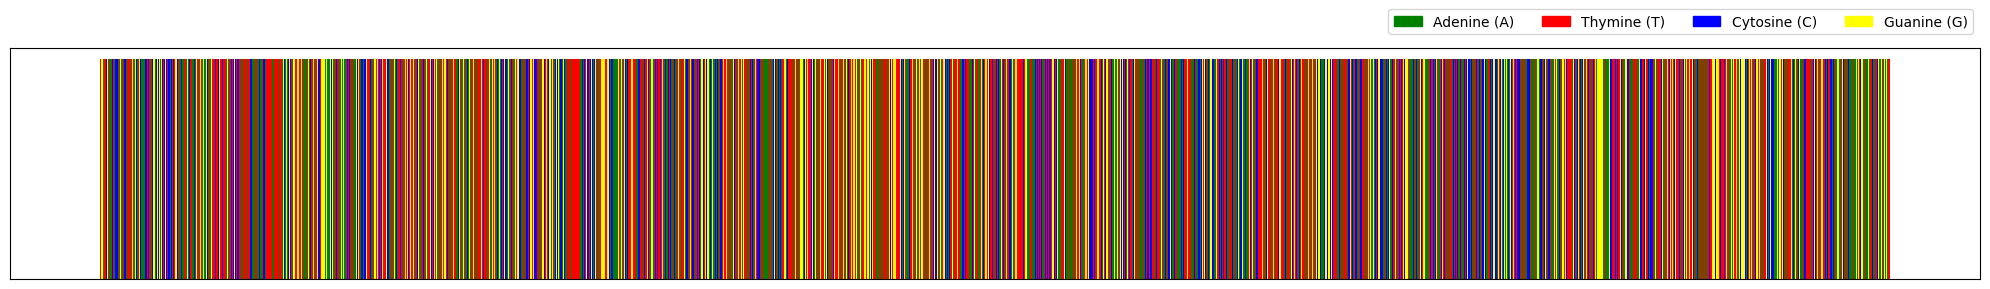

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dna_sequence(sequence):
    # Define colors for each base
    colors = {'A': 'green', 'T': 'red', 'C': 'blue', 'G': 'yellow'}
    # Create a list of colors for each base in the sequence
    color_sequence = [colors[base] for base in sequence]
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(20, 3))
    # Create a bar plot where each base is a bar with the corresponding color
    ax.bar(np.arange(len(sequence)), np.ones(len(sequence)), color=color_sequence, width=1)
    
    # Remove y-axis and ticks for clarity
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    
    # Add a legend
    handles = [plt.Rectangle((0,0),1,1, color=colors[base]) for base in 'ATCG']
    labels = ['Adenine (A)', 'Thymine (T)', 'Cytosine (C)', 'Guanine (G)']
    ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1.2), ncol=4)

    # Tight layout to maximize space used for the sequence
    plt.tight_layout()
    
    # Save the plot as a high-resolution PNG image
    plt.savefig('dna_sequence_plot.png', dpi=300)

    plt.show()

plot_dna_sequence(dna_sequence) # This line would be used to generate the plot


# Viterbi Algorithm

In [13]:
import math

def viterbi_log_space(observed_sequence, states, start_prob, trans_prob, emit_prob):
    # Initialize variables in log space
    V = [{}]
    path = {}
    log_zero = float('-inf')  # Representation of log(0)

    # Initialize the starting probabilities and paths in log space
    for state in states:
        if start_prob[state] > 0:
            V[0][state] = math.log(start_prob[state]) + math.log(emit_prob[state][observed_sequence[0]])
        else:
            V[0][state] = log_zero
        path[state] = [state]

    # Run Viterbi for t > 0
    for t in range(1, len(observed_sequence)):
        V.append({})
        newpath = {}

        for current_state in states:
            max_prob = log_zero
            max_state = None
            for prev_state in states:
                if V[t-1][prev_state] != log_zero and trans_prob[prev_state][current_state] > 0:
                    prob = V[t-1][prev_state] + math.log(trans_prob[prev_state][current_state]) + math.log(emit_prob[current_state][observed_sequence[t]])
                    if prob > max_prob or max_state is None:
                        max_prob = prob
                        max_state = prev_state

            V[t][current_state] = max_prob
            newpath[current_state] = path[max_state] + [current_state]

        # Don't need to keep old paths
        path = newpath

    # Find the final most probable state and its probability
    max_prob = log_zero
    max_state = None
    for state, prob in V[-1].items():
        if prob > max_prob or max_state is None:
            max_prob = prob
            max_state = state

    return (math.exp(max_prob), path[max_state])  # Convert log probability back to normal probability




In [14]:
# HMM Parameters
states = ['F', 'L']
start_prob = {'F': 1.0, 'L': 0.0}
trans_prob = {
    'F': {'F': 0.9, 'L': 0.1},
    'L': {'F': 0.1, 'L': 0.9}
}
emit_prob = {
    'F': {'1': 1/6, '2': 1/6, '3': 1/6, '4': 1/6, '5': 1/6, '6': 1/6},
    'L': {'1': 0.1, '2': 0.1, '3': 0.1, '4': 0.1, '5': 0.1, '6': 0.5}
}

# Observed sequence (the series of die rolls)
observed_sequence = list("3334436261666621166153666116265666666666252625124414246331346352415226341366646565326636646522325526")

# Running the Viterbi algorithm
prob, path = viterbi_log_space(observed_sequence, states, start_prob, trans_prob, emit_prob)

# Output the result
print("Probability of the Viterbi path:",prob)
print("Viterbi path:", ''.join(path))

Probability of the Viterbi path: 7.774406891455181e-76
Viterbi path: FFFFFFLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLFFFFFFFFF


In [15]:
## DNA Viterbi

# HMM Parameters
states =  ['AT Rich', 'CG Rich']
start_prob = {'AT Rich': 0.5, 'CG Rich': 0.5}
trans_prob = {
    'AT Rich': {'AT Rich': 0.9997, 'CG Rich': 0.0003},
    'CG Rich': {'AT Rich': 0.0002, 'CG Rich': 0.9998}
}
emit_prob = {
    'AT Rich': {'A': 0.2698, 'T': 0.3297, 'C': 0.2080, 'G': 0.1985},
    'CG Rich': {'A': 0.2459, 'T': 0.2079, 'C': 0.2478, 'G': 0.2984}
}

# Observed sequence (the series of die rolls)
f = open("DNA-Sequence", "r")
observed_sequence = f.read()
f.close()
# Running the Viterbi algorithm
prob, path = viterbi_log_space(observed_sequence, states, start_prob, trans_prob, emit_prob)

# Output the result
print("Probability of the Viterbi path:", prob)
print("Viterbi path:", ''.join(path))

Probability of the Viterbi path: 0.0
Viterbi path: AT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT RichAT R